In [205]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from altair import datum
import arviz as az
from scipy.stats import gaussian_kde

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [206]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked.trees"

In [207]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(trees, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [208]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [209]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [230]:
def enumerate_migration_events(tree, traitType):
        
    output_dict = {}
    migration_events_counter = 0
        
    for k in tree.Objects:
        trait = k.traits[traitType]
        parent_node = k.parent
        
        if traitType not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits[traitType]
        
            if trait != parent_trait:
                migration_events_counter += 1

                migration_event = parent_trait + "-to-" + trait
                #migration_date = parent_node.absoluteTime                

                # write to output dictionary
                output_dict[migration_events_counter] = {"type":migration_event, #"date":migration_date,
                                                        "parent_host":parent_trait,
                                                        "child_host": trait}
    
    return(output_dict)

In [231]:
all_trees = trees
burnin_percent = 0.1
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_81397/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:


238.60000000000002


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_81397/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


In [232]:
def run_mig_counts(all_trees, traitType):
    start_time = time.time()

    with open(all_trees, "r") as infile:

        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > burnin:
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                    tree.setAbsoluteTime(2023.0068)
                    trees_processed += 1

                    # iterate through the tree and pull out all migration events
                    migrations_dict[tree_counter] = enumerate_migration_events(tree, traitType)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
   
    """this will generate a multi-index dataframe from the migrations dictionary"""
    migrations_df = pd.DataFrame.from_dict({(i,j): migrations_dict[i][j] 
                           for i in migrations_dict.keys() 
                           for j in migrations_dict[i].keys()},
                       orient='index')

    migrations_df.reset_index(inplace=True)
    migrations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
    
    return(migrations_df)

In [233]:
migrations_df = run_mig_counts(all_trees, traitType ="country")

KeyError: 'country'

In [214]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

In [215]:
imports.index = imports.child_host
exports.index = exports.parent_host

In [216]:
#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [217]:
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }


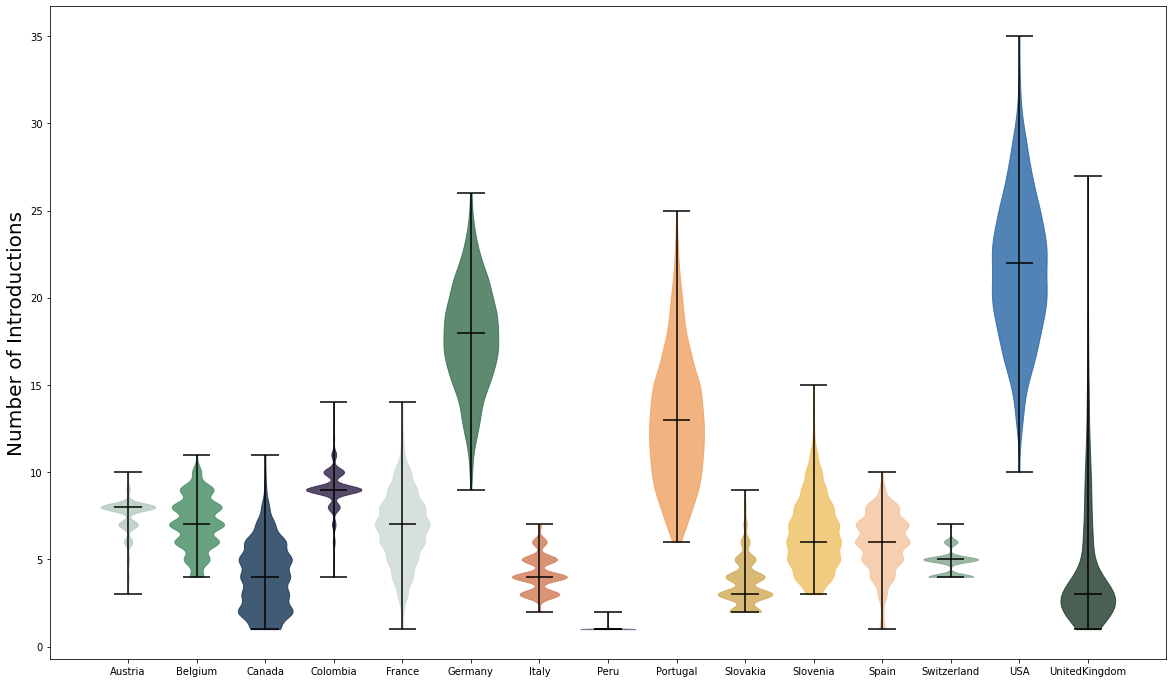

In [218]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_imports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_imports[place], positions =[index], widths=0.8,
                      showmedians=True)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(mig_dict_imports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Introductions", size=20)
plt.savefig('../figures/dta_country_intros.png',dpi=300,bbox_inches='tight')


plt.show()
    


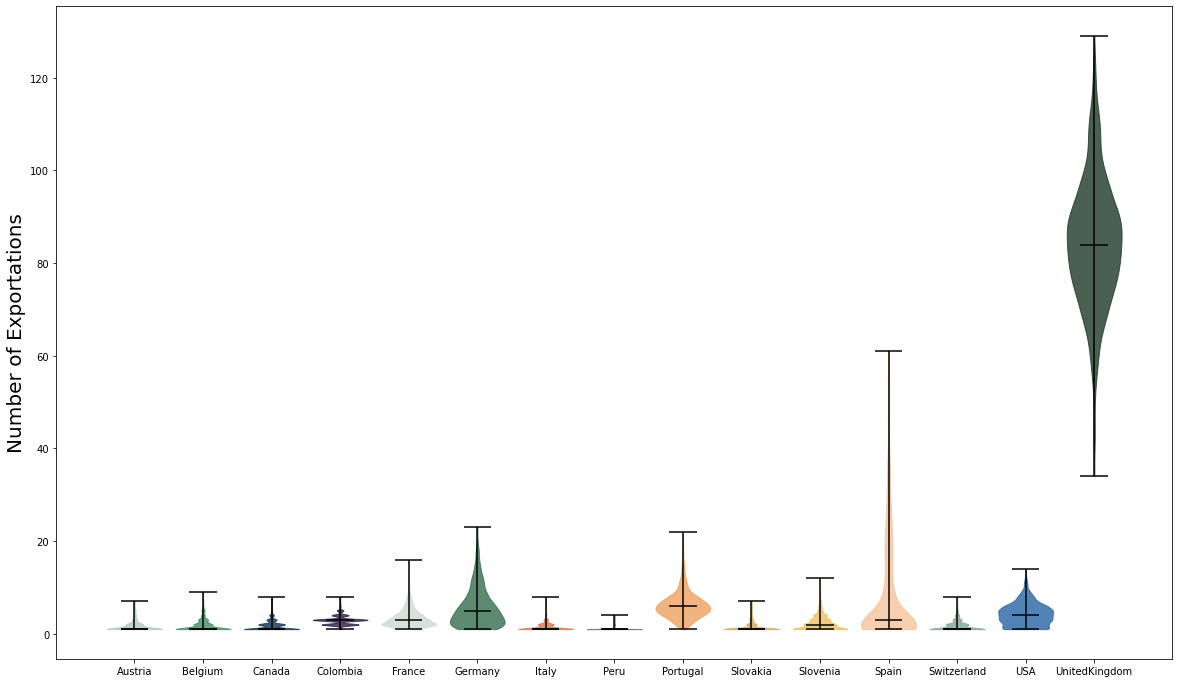

In [219]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_exports[place], positions =[index], widths=0.8,
                      showmedians=True)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(mig_dict_exports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Exportations", size=20)
plt.savefig('../figures/dta_country_exports.png',dpi=300,bbox_inches='tight')


plt.show()
    


## repeat for MASCOT

In [220]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/300_glm_region_unmasked.fixed_region_300.trees"

In [221]:
all_trees = trees
burnin_percent = 0.1
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_81397/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:


238.60000000000002


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_81397/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


In [234]:
migrations_df = run_mig_counts(all_trees, traitType = "max")

this took 66.2970929145813 seconds ( 1.104951548576355  minutes) to run on 2148 trees


In [235]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

In [236]:
imports.index = imports.child_host
exports.index = exports.parent_host

In [237]:
#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [238]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

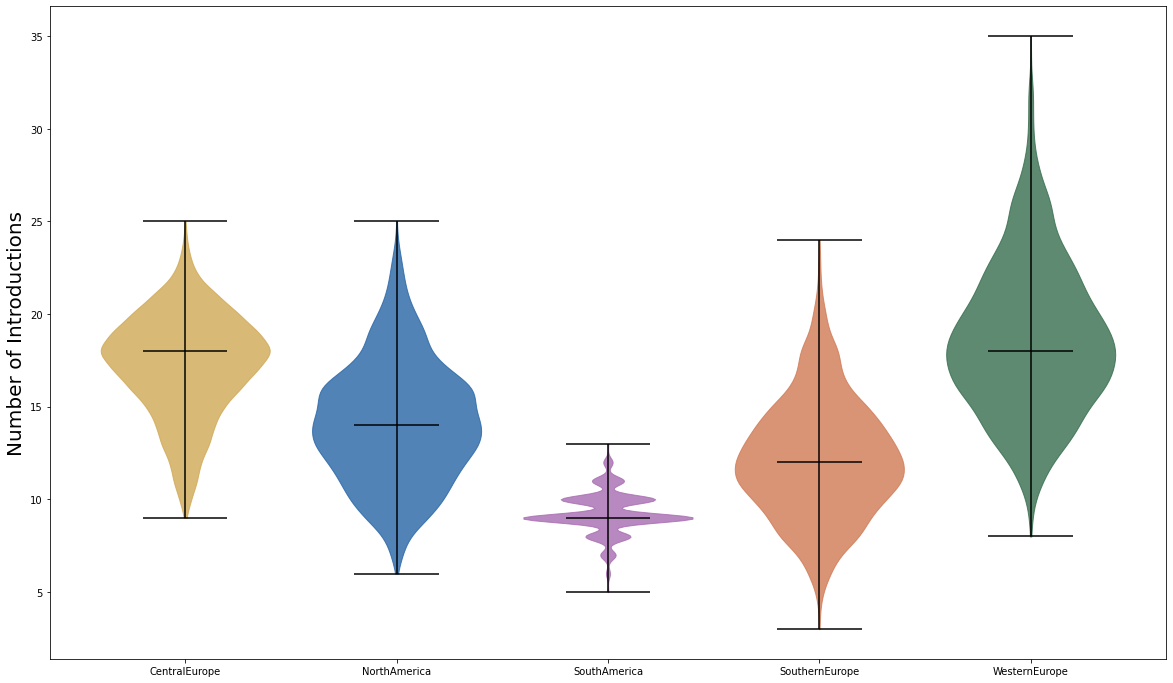

In [239]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_imports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_imports[place], positions =[index], widths=0.8,
                      showmedians=True)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Introductions", size=20)
plt.savefig('../figures/glm_region_intros.png',dpi=300,bbox_inches='tight')


plt.show()
    


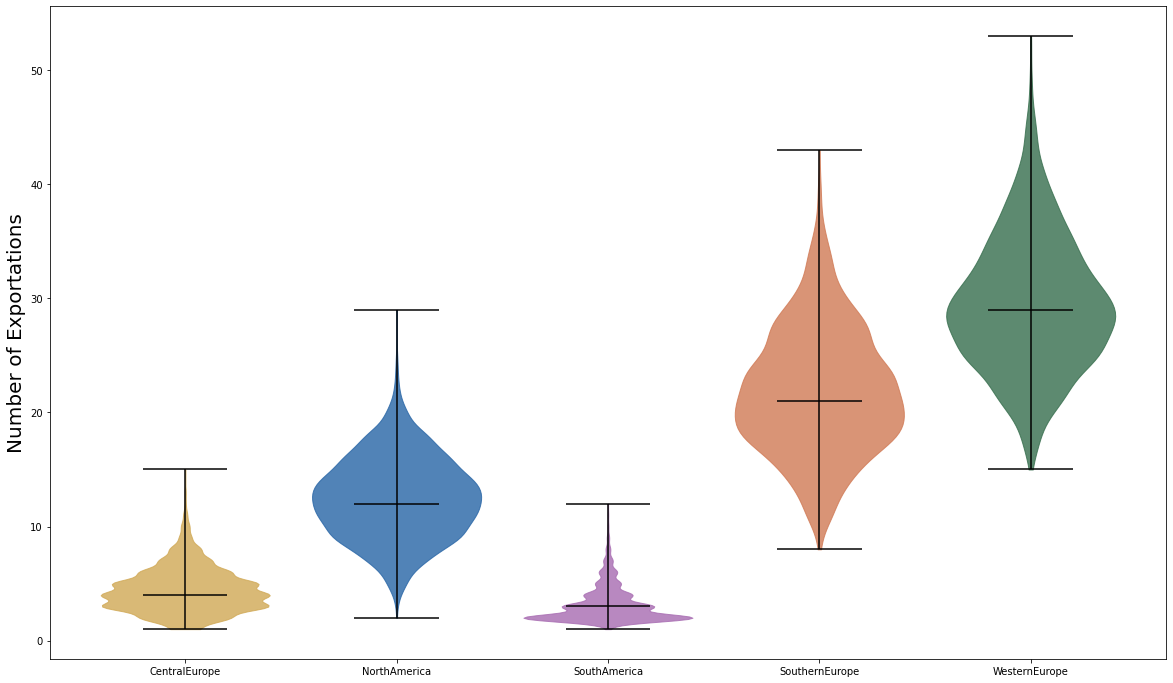

In [240]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_exports[place], positions =[index], widths=0.8,
                      showmedians=True)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Exportations", size=20)
plt.savefig('../figures/dta_country_exports.png',dpi=300,bbox_inches='tight')


plt.show()
    
